# Subject - GAN
> 전공 : 빅데이터융합학과  
> 학번 : 212806  
> 이름 : 김재현  


# Model

Files already downloaded and verified
[Epoch 1/10] [C Loss: -0.2465] [G Loss: 0.1943]
[Epoch 2/10] [C Loss: -0.3160] [G Loss: 0.1973]
[Epoch 3/10] [C Loss: -0.2942] [G Loss: 0.1796]
[Epoch 4/10] [C Loss: -0.3311] [G Loss: 0.1429]
[Epoch 5/10] [C Loss: -0.3001] [G Loss: 0.1345]
[Epoch 6/10] [C Loss: -0.2995] [G Loss: 0.1830]
[Epoch 7/10] [C Loss: -0.2481] [G Loss: 0.1990]
[Epoch 8/10] [C Loss: -0.2565] [G Loss: 0.1441]
[Epoch 9/10] [C Loss: -0.2334] [G Loss: 0.1504]
[Epoch 10/10] [C Loss: -0.2554] [G Loss: 0.1450]


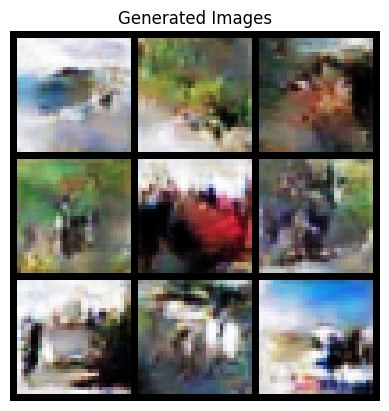

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Generator 클래스 정의
class Generator(nn.Module):
    """
    Generator는 조건부 GAN에서 조건을 받아 이미지를 생성하는 모델입니다.
    랜덤 노이즈와 레이블을 입력받아 가짜 이미지를 생성합니다.
    """
    def __init__(self, latent_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)  # 레이블을 임베딩하여 조건으로 사용
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size**2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 업샘플링하여 이미지를 점차적으로 확대
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()  # 출력 이미지는 -1과 1 사이로 정규화
        )

    def forward(self, noise, labels):
        """
        랜덤 노이즈와 레이블을 입력받아 이미지를 생성합니다.
        """
        label_input = self.label_embed(labels)  # 레이블 임베딩
        gen_input = torch.cat((noise, label_input), -1)  # 노이즈와 레이블을 결합
        out = self.l1(gen_input)  # 첫 번째 레이어를 통과
        out = out.view(out.size(0), 128, self.init_size, self.init_size)  # 이미지 크기로 reshape
        img = self.conv_blocks(out)  # 업샘플링 및 합성곱 블록을 통과
        return img

# Critic 클래스 정의
class Critic(nn.Module):
    """
    Critic은 WGAN의 목적 함수에서 중요한 역할을 하며, 생성된 이미지의 진위 여부를 평가합니다.
    이 모델은 조건부 GAN에서 레이블을 포함하여 이미지를 평가합니다.
    """
    def __init__(self, num_classes, img_size):
        super(Critic, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)  # 레이블 임베딩
        self.model = nn.Sequential(
            nn.Conv2d(3 + num_classes, 64, 4, stride=2, padding=1),  # 입력 이미지와 레이블 결합 후 합성곱
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, stride=1, padding=0)  # 최종 출력은 스칼라 값
        )

    def forward(self, img, labels):
        """
        이미지를 입력받고, 레이블을 결합하여 이미지를 평가합니다.
        """
        label_input = self.label_embed(labels).unsqueeze(2).unsqueeze(3)  # 레이블 임베딩
        label_input = label_input.expand(img.size(0), label_input.size(1), img.size(2), img.size(3))  # 이미지 크기에 맞게 확장
        d_in = torch.cat((img, label_input), 1)  # 이미지와 레이블을 채널 차원으로 결합
        validity = self.model(d_in)  # 평가 모델 통과
        return validity.view(-1)  # 1D 벡터로 변환하여 반환

# 데이터 로딩 및 전처리 모듈
def load_data(batch_size=64):
    """
    CIFAR-10 데이터셋을 로드하고, 데이터 전처리 및 DataLoader를 설정합니다.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]로 정규화
    ])
    cifar10 = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)
    return dataloader

# 학습 함수 모듈
def train_model(generator, critic, dataloader, optimizer_G, optimizer_C, n_epochs, n_critic, clip_value, device):
    """
    Generator와 Critic을 학습시키는 함수입니다.
    - n_critic: Critic을 몇 번 학습시킬지 결정하는 값
    - clip_value: WGAN에서 가중치를 클리핑할 때 사용하는 값
    """
    for epoch in range(n_epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Critic 학습
            optimizer_C.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)  # 노이즈 생성
            fake_imgs = generator(z, labels).detach()  # 생성된 가짜 이미지

            real_loss = critic(imgs, labels).mean()  # 진짜 이미지에 대한 평가
            fake_loss = critic(fake_imgs, labels).mean()  # 가짜 이미지에 대한 평가
            critic_loss = -(real_loss - fake_loss)  # WGAN에서의 Critic 손실 계산
            critic_loss.backward()
            optimizer_C.step()

            # 가중치 클리핑
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)
            
            # Generator 학습 (n_critic 주기마다)
            if i % n_critic == 0:
                optimizer_G.zero_grad()
                gen_imgs = generator(z, labels)
                generator_loss = -critic(gen_imgs, labels).mean()  # Generator 손실
                generator_loss.backward()
                optimizer_G.step()

        print(f"[Epoch {epoch+1}/{n_epochs}] [C Loss: {critic_loss.item():.4f}] [G Loss: {generator_loss.item():.4f}]")

# 이미지 생성 및 결과 시각화
def show_generated_images(generator, latent_dim, num_classes, device):
    """
    학습된 Generator를 사용하여 이미지를 생성하고 시각화합니다.
    """
    z = torch.randn(9, latent_dim).to(device)  # 랜덤 노이즈 생성
    labels = torch.randint(0, num_classes, (9,)).to(device)  # 랜덤 레이블 생성
    with torch.no_grad():
        gen_imgs = generator(z, labels)
        gen_imgs = (gen_imgs * 0.5) + 0.5  # [-1, 1]에서 [0, 1]로 변환
        grid = vutils.make_grid(gen_imgs, nrow=3)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title("Generated Images")
        plt.axis("off")
        plt.show()

# 하이퍼파라미터 설정
latent_dim = 100
num_classes = 10
img_size = 32
batch_size = 64
n_epochs = 50
n_critic = 5
clip_value = 0.01
lr = 0.00005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
generator = Generator(latent_dim, num_classes, img_size).to(device)
critic = Critic(num_classes, img_size).to(device)

# 최적화 함수 설정
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

# 데이터 로딩
dataloader = load_data(batch_size)

# 모델 학습
train_model(generator, critic, dataloader, optimizer_G, optimizer_C, n_epochs, n_critic, clip_value, device)

# 학습된 모델을 사용하여 이미지 생성 및 시각화
show_generated_images(generator, latent_dim, num_classes, device)


Files already downloaded and verified
[Epoch 1/50] [C Loss: -0.2144] [G Loss: 0.1608]
[Epoch 2/50] [C Loss: -0.2895] [G Loss: 0.1889]
[Epoch 3/50] [C Loss: -0.3388] [G Loss: 0.1643]
[Epoch 4/50] [C Loss: -0.2765] [G Loss: 0.1600]
[Epoch 5/50] [C Loss: -0.2960] [G Loss: 0.1904]
[Epoch 6/50] [C Loss: -0.3190] [G Loss: 0.1501]
[Epoch 7/50] [C Loss: -0.2335] [G Loss: 0.0742]
[Epoch 8/50] [C Loss: -0.2898] [G Loss: 0.1375]
[Epoch 9/50] [C Loss: -0.2445] [G Loss: 0.0984]
[Epoch 10/50] [C Loss: -0.1995] [G Loss: 0.1049]
[Epoch 11/50] [C Loss: -0.2480] [G Loss: 0.1209]
[Epoch 12/50] [C Loss: -0.1976] [G Loss: 0.1254]
[Epoch 13/50] [C Loss: -0.1579] [G Loss: 0.1481]
[Epoch 14/50] [C Loss: -0.1970] [G Loss: 0.1470]
[Epoch 15/50] [C Loss: -0.1694] [G Loss: 0.0865]
[Epoch 16/50] [C Loss: -0.1879] [G Loss: 0.0973]
[Epoch 17/50] [C Loss: -0.1312] [G Loss: 0.0822]
[Epoch 18/50] [C Loss: -0.2275] [G Loss: 0.0829]
[Epoch 19/50] [C Loss: -0.1467] [G Loss: 0.0754]
[Epoch 20/50] [C Loss: -0.2018] [G Loss:

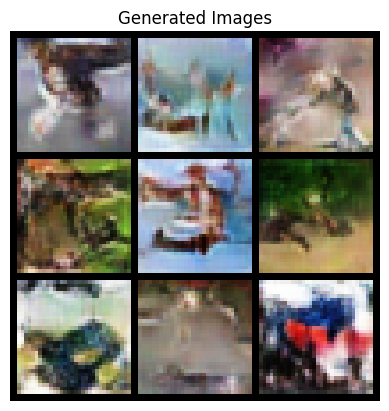

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils


# 1. 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터셋 로드 (CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]로 정규화
])
cifar10 = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(cifar10, batch_size=64, shuffle=True)

# 3. Generator 정의
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size**2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_embed(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# 4. Critic(Discriminator) 정의
class Critic(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Critic, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(3 + num_classes, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, stride=1, padding=0)
        )

    def forward(self, img, labels):
        label_input = self.label_embed(labels).unsqueeze(2).unsqueeze(3)  # (batch_size, num_classes, 1, 1)
        label_input = label_input.expand(img.size(0), label_input.size(1), img.size(2), img.size(3))  # (batch_size, num_classes, height, width)
        d_in = torch.cat((img, label_input), 1)  # 채널 차원 기준으로 결합
        validity = self.model(d_in)
        return validity.view(-1)

# 5. 하이퍼파라미터 설정
latent_dim = 100
num_classes = 10
img_size = 32
lr = 0.00005
n_epochs = 50
n_critic = 5
clip_value = 0.01

# 가중치 저장 주소
path = './weight/'

# 모델 초기화
generator = Generator(latent_dim, num_classes, img_size).to(device)
critic = Critic(num_classes, img_size).to(device)

# 최적화 함수
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

# 6. 학습 루프
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Critic 학습
        optimizer_C.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z, labels).detach()
        
        real_loss = critic(imgs, labels).mean()
        fake_loss = critic(fake_imgs, labels).mean()
        critic_loss = -(real_loss - fake_loss)
        critic_loss.backward()
        optimizer_C.step()
        
        # 가중치 클리핑
        for p in critic.parameters():
            p.data.clamp_(-clip_value, clip_value)
        
        # Generator 학습 (n_critic 주기마다)
        if i % n_critic == 0:
            optimizer_G.zero_grad()
            gen_imgs = generator(z, labels)
            generator_loss = -critic(gen_imgs, labels).mean()
            generator_loss.backward()
            optimizer_G.step()

    print(f"[Epoch {epoch+1}/{n_epochs}] [C Loss: {critic_loss.item():.4f}] [G Loss: {generator_loss.item():.4f}]")

# 7. 결과 확인
def show_generated_images():
    z = torch.randn(9, latent_dim).to(device)
    labels = torch.randint(0, num_classes, (9,)).to(device)
    with torch.no_grad():
        gen_imgs = generator(z, labels)
        gen_imgs = (gen_imgs * 0.5) + 0.5  # [-1, 1]에서 [0, 1]로 변환
        grid = vutils.make_grid(gen_imgs, nrow=3)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title("Generated Images")
        plt.axis("off")
        plt.show()

show_generated_images()




In [27]:
# 모델 가중치 저장 함수 (epoch을 파일명에 포함시킴)
def save_model_weights(generator, critic, epoch, path):
    """
    모델의 가중치를 저장하는 함수. 파일명에 epoch 번호를 추가.
    """
    # epoch을 포함한 파일명 생성
    epoch_path = f"{path}_epoch_{epoch}.pth"
    
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'critic_state_dict': critic.state_dict(),
    }, epoch_path)
    
    print(f"모델 가중치를 {epoch_path}에 저장했습니다.")

save_model_weights(generator, critic, epoch, path)

모델 가중치를 ./weight_epoch_49.pth_epoch_100.pth에 저장했습니다.


In [28]:
# 모델 가중치 불러오기 함수
def load_model_weights(generator, critic, path):
    """
    저장된 모델의 가중치를 불러오는 함수.
    """
    checkpoint = torch.load(path)
    epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['generator_state_dict'])
    critic.load_state_dict(checkpoint['critic_state_dict'])
    print(f"모델 가중치를 {path}에서 불러왔습니다. 마지막 epoch: {epoch}")
    return epoch

# 모델 불러오기 (가정: generator와 critic은 미리 정의된 모델)
path = './weight_epoch_49.pth'  # 가중치 경로 (파일 확장자는 제외)

# 저장된 모델의 가중치를 불러오기
last_epoch = load_model_weights(generator, critic, path)

# 이어서 학습하기
num_epochs = 100  # 총 학습 epoch 수

# 이미 학습한 epoch이 50이라면, 51번째 epoch부터 학습 시작
start_epoch = last_epoch + 1 if last_epoch < num_epochs else num_epochs

# 학습 루프 (학습 코드 예시)
for epoch in range(start_epoch, num_epochs + 1):
    # 학습 루프 (학습 코드 작성)
    train_model(generator, critic, dataloader, optimizer_G, optimizer_C, n_epochs, n_critic, clip_value, device)
    # 예시: train_one_epoch(generator, critic)
    
    # 10 epoch마다 모델 가중치 저장
    if epoch % 10 == 0:
        save_model_weights(generator, critic, epoch, path)
    
    print(f"Epoch {epoch}/{num_epochs} 진행 중...")
    
    # 이 부분에 학습 코드 작성 (예: optimizer, loss 계산 등)
    # train_one_epoch(generator, critic)


/tmp/ipykernel_13006/3121891327.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


모델 가중치를 ./weight_epoch_49.pth에서 불러왔습니다. 마지막 epoch: 49
[Epoch 1/10] [C Loss: -0.1032] [G Loss: 0.0560]
[Epoch 2/10] [C Loss: -0.0899] [G Loss: 0.0423]
[Epoch 3/10] [C Loss: -0.0906] [G Loss: 0.0716]
[Epoch 4/10] [C Loss: -0.0986] [G Loss: 0.0595]
[Epoch 5/10] [C Loss: -0.0871] [G Loss: 0.0502]
[Epoch 6/10] [C Loss: -0.0796] [G Loss: 0.0543]
[Epoch 7/10] [C Loss: -0.0703] [G Loss: 0.0658]
[Epoch 8/10] [C Loss: -0.0417] [G Loss: 0.0379]
[Epoch 9/10] [C Loss: -0.1391] [G Loss: 0.0783]
[Epoch 10/10] [C Loss: -0.0749] [G Loss: 0.0590]
모델 가중치를 ./weight_epoch_49.pth_epoch_50.pth에 저장했습니다.
Epoch 50/100 진행 중...
[Epoch 1/10] [C Loss: -0.0595] [G Loss: 0.0276]
[Epoch 2/10] [C Loss: -0.0606] [G Loss: 0.0452]
[Epoch 3/10] [C Loss: -0.0701] [G Loss: 0.0305]
[Epoch 4/10] [C Loss: -0.0802] [G Loss: 0.0653]
[Epoch 5/10] [C Loss: -0.0522] [G Loss: 0.0461]
[Epoch 6/10] [C Loss: -0.1065] [G Loss: 0.0438]
[Epoch 7/10] [C Loss: -0.0739] [G Loss: 0.1055]
[Epoch 8/10] [C Loss: -0.0888] [G Loss: 0.0242]
[Epoch 9

KeyboardInterrupt: 

# Inference

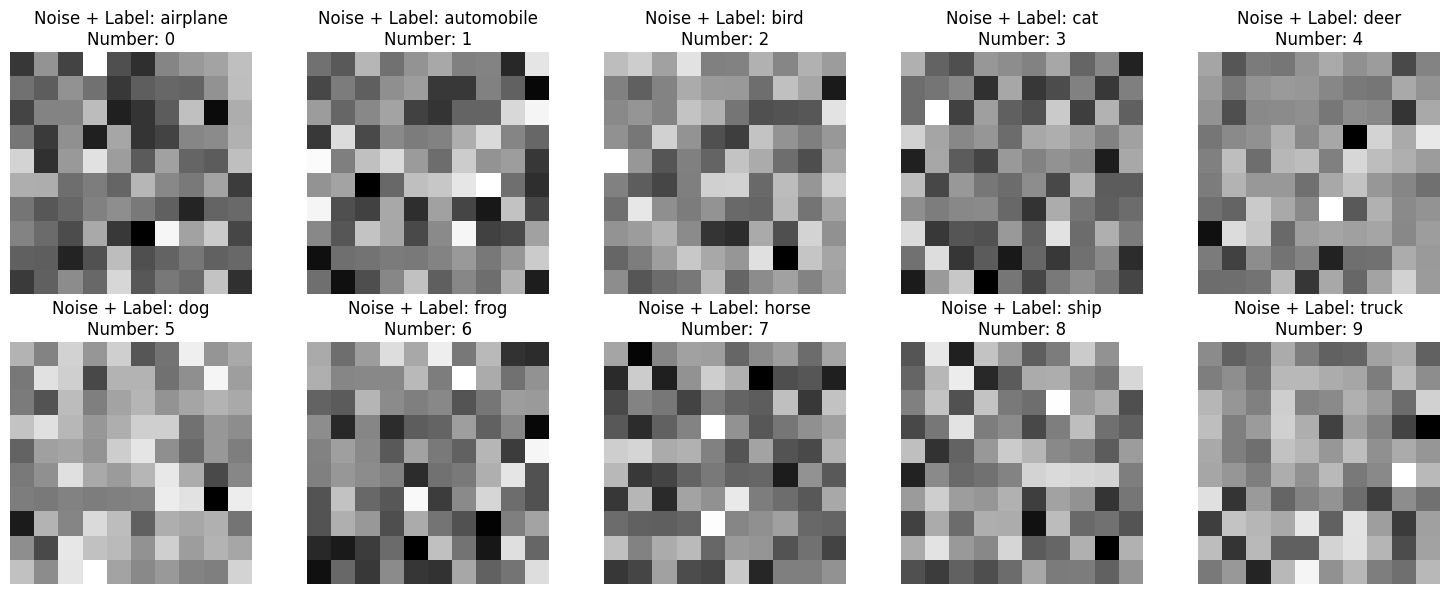

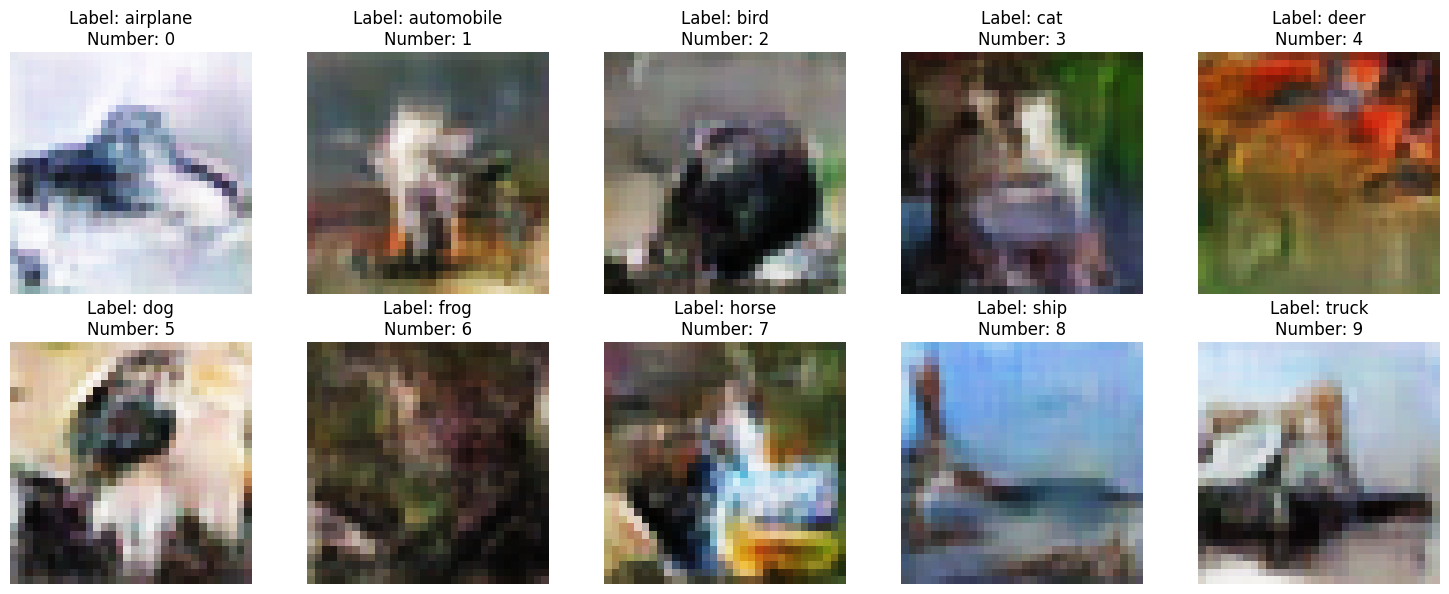

In [23]:
# CIFAR-10 라벨에 대한 영어 텍스트 매핑
label_to_english = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def show_noise_and_generated_images(generator, num_classes=10, latent_dim=100):
    """
    CIFAR-10의 10개 라벨에 대해 노이즈 벡터와 생성된 이미지를 함께 표시합니다.
    :param generator: 학습된 Generator 모델
    :param num_classes: CIFAR-10의 클래스 개수 (10)
    :param latent_dim: 노이즈 벡터의 차원
    """
    generator.eval()
    with torch.no_grad():
        # 10개 라벨 각각에 대해 이미지 생성
        z = torch.randn(10, latent_dim).to(device)  # 10개 노이즈 벡터 생성
        labels = torch.arange(0, num_classes).to(device)  # 0부터 9까지 라벨 생성
        
        # 노이즈 벡터와 라벨 시각화
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2x5 배열로 이미지 배치
        axes = axes.flatten()

        for i in range(num_classes):
            # 노이즈 벡터
            noise_img = z[i].cpu().numpy().reshape(10, 10)  # 노이즈 벡터를 10x10 배열로 변환하여 표시
            axes[i].imshow(noise_img, cmap='gray')
            axes[i].set_title(f"Noise + Label: {label_to_english[labels[i].item()]}\nNumber: {labels[i].item()}")
            axes[i].axis("off")
        
        plt.tight_layout()
        plt.show()

        # 생성된 이미지
        gen_imgs = generator(z, labels)
        gen_imgs = (gen_imgs * 0.5) + 0.5  # [-1, 1]에서 [0, 1]로 변환

        # 생성된 이미지 시각화
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2x5 배열로 이미지 배치
        axes = axes.flatten()

        for i in range(num_classes):
            # 생성된 이미지
            img = gen_imgs[i].cpu().numpy().transpose(1, 2, 0)  # CHW -> HWC 변환
            label_english = label_to_english[labels[i].item()]  # 영어 라벨 추출
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {label_english}\nNumber: {labels[i].item()}")  # 영어 라벨과 숫자 라벨 표시
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

# 학습된 모델을 통해 노이즈 벡터와 생성된 이미지 시각화
show_noise_and_generated_images(generator)
